In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import seaborn as sns
from api_keys import weather_api_key


file = "Resources/kaggle_income.csv"

df_main = pd.read_csv(file)

# Limit the dataset to mainland USA (Lat 25 ~ 50, Lon -66 ~ -126)
df_main = df_main[(df_main["Lat"] > 25) & (df_main["Lat"] < 50) & (df_main["Lon"] > -126) & (df_main["Lon"] < 66)]

# Add new columnes for "Number of Households", "Population Density", and "Percentage of Water Area"
df_main["Number of Households"] = df_main["sum_w"] / df_main["Mean"]
df_main["Pop density"] = round(df_main["Number of Households"] / (df_main["ALand"] + df_main["AWater"]) *100000000000000,0)
df_main["Water%"] = df_main["AWater"] / (df_main["ALand"] + df_main["AWater"]) * 100


# Function to return dataframe optimized for plotting - Use when you want to plot using values outside df_main (ex : API)
def PlotvsIncome(df1,df2,para,interval):

    df = pd.merge(df1, df2, on="City", how="right")
    temp_bin =[] 
    bin_name = []

    for n in np.arange(min(df[para]),max(df[para]),interval):
        temp_bin.append(n)

    bin_name = temp_bin[1:]

    df[para+"'"] = pd.cut(df[para], temp_bin, labels = bin_name)
    df_plot = df.groupby([para+"'"]).sum()
    df_plot["Mean Household Income"] = df_plot["sum_w"] / df_plot["Number of Households"]
    df_plot = df_plot.reset_index()
    df_plot[para+"'"] = df_plot[para+"'"].astype(int)
    df_plot = df_plot.dropna(how='any')
    
    return df_plot, para+"'"

# Function to return dataframe optimized for plotting - Use when you want to plot using only the values inside df_main
def PlotvsIncome_self(df,para,interval):

    temp_bin =[] 
    bin_name = []

    for n in np.arange(min(df[para]),max(df[para]),interval):
        temp_bin.append(n)

    bin_name = temp_bin[1:]

    df[para+"'"] = pd.cut(df[para], temp_bin, labels = bin_name)
    df_plot = df.groupby([para+"'"]).sum()
    df_plot["Mean Household Income"] = df_plot["sum_w"] / df_plot["Number of Households"]
    df_plot = df_plot.reset_index()
    df_plot[para+"'"] = df_plot[para+"'"].astype(int)
    df_plot = df_plot.dropna(how='any')
    
    return df_plot, para+"'"

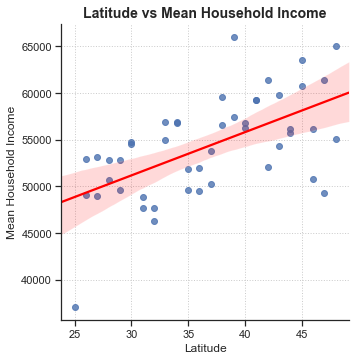

slope: 462.560771    intercept: 37306.057251
r: 0.589697     p: 0.000013     standard error: 94.437322


In [20]:
#Plot 1 : Latitude vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Lat"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 
df_plot, para = PlotvsIncome_self(df_main,Parameter, Interval )

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('Latitude vs Mean Household Income',fontsize=14,fontweight='bold')
plt.xlabel('Latitude',fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

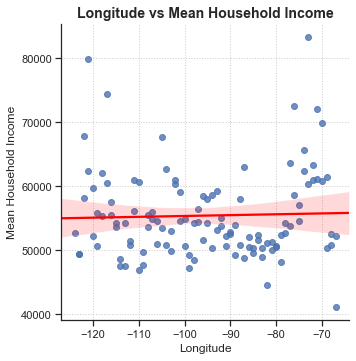

slope: 13.341725    intercept: 56700.958125
r: 0.032254     p: 0.732205     standard error: 38.892439


In [6]:
#Plot 2 : Longitude vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Lon"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 
df_plot, para = PlotvsIncome_self(df_main,Parameter, Interval )

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('Longitude vs Mean Household Income',fontsize=14,fontweight='bold')
plt.xlabel('Longitude',fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

In [7]:
# API Calling from Openweathermap.org
#-------------------------------------------------------

url = "http://api.openweathermap.org/data/2.5/weather?"

df_weather = pd.DataFrame(columns = ["City","Feels Like Temp(F)","Humidity(%)","Pressure(hPa)"])


# Sampling of 3000 cities from df_main.
cities=[]
cities_rand_num = np.random.randint(low=0, high=len(df_main["City"]), size=3000)

for n in cities_rand_num:
    try:
        cities.append(df_main["City"][n])
    except:
        next

# API calling and saving result into df_weather        
count = 0
for city in cities:
    try:
        print("Processing City {}".format(count))
        query_url = url + "appid=" + weather_api_key + "&q=" + city
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        temp = round((int(weather_json["main"]["feels_like"]) - 273.15) * 9/5 + 32,2)
        humidity = weather_json["main"]["humidity"]
        pressure = weather_json["main"]["pressure"]

        new_row = []
        new_row.append(city)
        new_row.append(temp)
        new_row.append(humidity)
        new_row.append(pressure)
        df_weather.loc[count] = new_row
        count = count + 1
    except:
        print("Encountered Error, Skipping...")

Processing City 0
Processing City 1
Processing City 2
Processing City 3
Processing City 4
Processing City 5
Processing City 6
Processing City 7
Processing City 8
Processing City 9
Processing City 10
Processing City 11
Processing City 12
Processing City 13
Processing City 14
Processing City 15
Processing City 16
Processing City 17
Processing City 18
Processing City 19
Processing City 20
Processing City 21
Processing City 22
Processing City 23
Processing City 24
Processing City 25
Processing City 26
Processing City 27
Processing City 28
Processing City 29
Processing City 30
Processing City 31
Processing City 32
Processing City 33
Processing City 34
Processing City 35
Processing City 36
Processing City 37
Processing City 38
Processing City 39
Encountered Error, Skipping...
Processing City 39
Processing City 40
Processing City 41
Processing City 42
Processing City 43
Processing City 44
Processing City 45
Encountered Error, Skipping...
Processing City 45
Processing City 46
Processing City 4

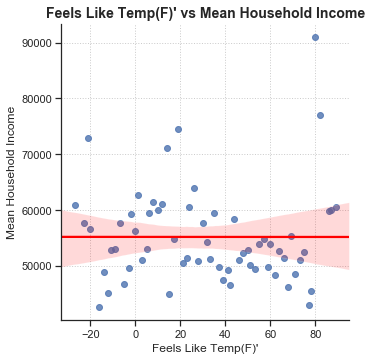

slope: -0.121508    intercept: 55183.131661
r: -0.000469     p: 0.997086     standard error: 33.136587


In [17]:
#Plot 3 : Temperature vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Feels Like Temp(F)"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 

df_plot, para = PlotvsIncome(df_main,df_weather,Parameter,Interval)

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(para),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(para),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

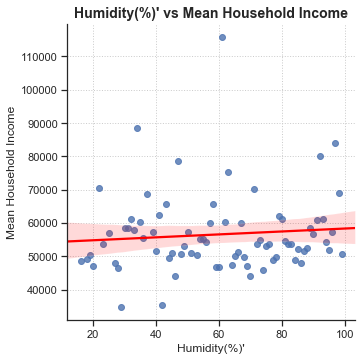

slope: 44.036902    intercept: 53938.178094
r: 0.089180     p: 0.437482     standard error: 56.416611


In [18]:
#Plot 4 : Humidity vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Humidity(%)"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 

df_plot, para = PlotvsIncome(df_main,df_weather,Parameter,Interval)

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(para),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(para),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

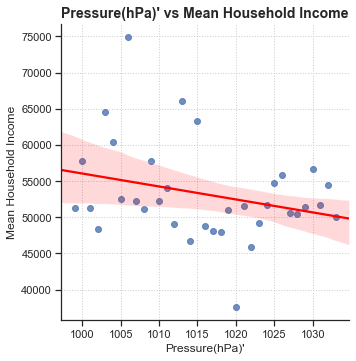

slope: -179.223919    intercept: 235271.043297
r: -0.276232     p: 0.108211     standard error: 108.550113


In [19]:
#Plot 5 : Pressure vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Pressure(hPa)"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 

df_plot, para = PlotvsIncome(df_main,df_weather,Parameter,Interval)

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(para),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(para),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

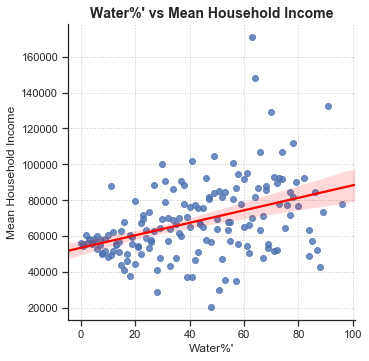

slope: 348.980701    intercept: 53373.533999
r: 0.406152     p: 0.000000     standard error: 61.689165


In [21]:
#Plot 6 : Water% vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Water%"
Interval = 0.5
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 

df_plot, para = PlotvsIncome(df_main,df_weather,Parameter,Interval)

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(para),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(para),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))

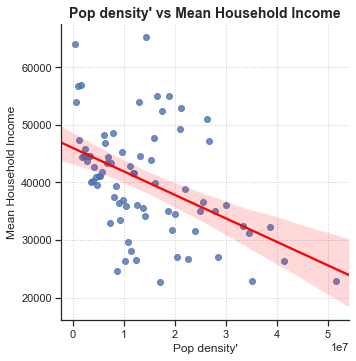

slope: -0.000407    intercept: 45972.045207
r: -0.458529     p: 0.000031     standard error: 0.000092


In [26]:
#Plot 7 : Population Density vs Mean Household Income

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Pop density"
Interval = 300000
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 

df_plot, para = PlotvsIncome(df_main,df_weather,Parameter,Interval)

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(para),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(para),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))